<a href="https://colab.research.google.com/github/sg5g10/VBODE/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Let’s begin by importing the libraries and the datasets.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import ContinuousBernoulli, Bernoulli

In [2]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



## Now, we define a Encoder, Decoder class

The encoder and decoder networks contain three convolutional layers and two fully connected layers. Some batch normalisation layers are added to have more robust features in the latent space. 

In [3]:
class VariationalEncoder(nn.Module):
  def __init__(self, latent_dims):  
    super(VariationalEncoder, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
    self.batch2 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
    self.linear1 = nn.Linear(3*3*32, 128)
    self.linear2 = nn.Linear(128, latent_dims)
    self.linear3 = nn.Linear(128, latent_dims)

    self.N = torch.distributions.Normal(0, 1)
    self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
    self.N.scale = self.N.scale.cuda()
    self.kl = 0

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.batch2(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.linear1(x))
    mu =  self.linear2(x)
    sigma = torch.exp(self.linear3(x))
    z = mu + sigma*self.N.sample(mu.shape)
    self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z   

In [4]:
class Decoder(nn.Module):
    
  def __init__(self, latent_dims):
    super().__init__()

    self.decoder_lin = nn.Sequential(
        nn.Linear(latent_dims, 128),
        nn.ReLU(True),
        nn.Linear(128, 3 * 3 * 32),
        nn.ReLU(True)
    )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

    self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
    )
    
  def forward(self, x):
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)
    return x

## Combine them together in a VAE class

In [5]:
class VariationalAutoencoder(nn.Module):
  def __init__(self, latent_dims):
    super(VariationalAutoencoder, self).__init__()
    self.encoder = VariationalEncoder(latent_dims)
    self.decoder = Decoder(latent_dims)

  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z)

Finally, we can initialize the VariationalAutoencoder class, the optimizer and the device to use the GPU in the code.



In [6]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

### Training function

In [7]:
def train_epoch(vae, device, dataloader, optimizer):
  # Set train mode for both the encoder and the decoder
  vae.train()
  train_loss = 0.0
  # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
  for x, _ in dataloader: 
    # Move tensor to the proper device
    x = x.to(device)
    x_hat = vae(x)
    # Evaluate loss
    loss = nn.functional.binary_cross_entropy(
        x_hat.view(-1, 784), x.view(-1, 784), reduction='sum'
    ) + vae.encoder.kl

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Print batch loss
    print('\t partial train loss (single batch): %f' % (loss.item()))
    train_loss+=loss.item()

  return train_loss / len(dataloader.dataset)

### Testing function

In [8]:
def test_epoch(vae, device, dataloader):
  # Set evaluation mode for encoder and decoder
  vae.eval()
  val_loss = 0.0
  with torch.no_grad(): # No need to track the gradients
    for x, _ in dataloader:
      # Move tensor to the proper device
      x = x.to(device)
      # Encode data
      encoded_data = vae.encoder(x)
      # Decode data
      x_hat = vae(x)
      loss = nn.functional.binary_cross_entropy(
        x_hat.view(-1, 784), x.view(-1, 784), reduction='sum'
      ) + vae.encoder.kl
      val_loss += loss.item()

  return val_loss / len(dataloader.dataset)

### Plotting code

In [9]:
def plot_ae_outputs(encoder,decoder,n=10):
  plt.figure(figsize=(16,4.5))
  targets = test_dataset.targets.numpy()
  t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
  for i in range(n):
    ax = plt.subplot(2,n,i+1)
    img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    if i == n//2:
      ax.set_title('Original images')
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    if i == n//2:
        ax.set_title('Reconstructed images')
  plt.show()  

## Lets train the VAE

	 partial train loss (single batch): 189808.984375
	 partial train loss (single batch): 185863.671875
	 partial train loss (single batch): 180860.750000
	 partial train loss (single batch): 178493.062500
	 partial train loss (single batch): 176098.625000
	 partial train loss (single batch): 173661.812500
	 partial train loss (single batch): 171860.625000
	 partial train loss (single batch): 169882.312500
	 partial train loss (single batch): 168344.031250
	 partial train loss (single batch): 167414.687500
	 partial train loss (single batch): 166013.875000
	 partial train loss (single batch): 164777.468750
	 partial train loss (single batch): 163530.015625
	 partial train loss (single batch): 161993.937500
	 partial train loss (single batch): 161259.500000
	 partial train loss (single batch): 160599.640625
	 partial train loss (single batch): 158992.953125
	 partial train loss (single batch): 158538.531250
	 partial train loss (single batch): 157351.875000
	 partial train loss (single ba

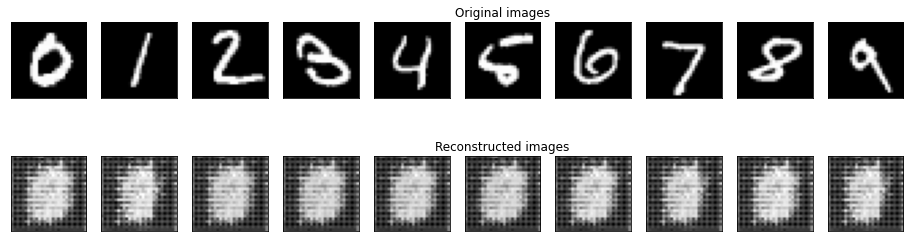

	 partial train loss (single batch): 76893.171875
	 partial train loss (single batch): 76953.164062
	 partial train loss (single batch): 77139.937500
	 partial train loss (single batch): 76730.312500
	 partial train loss (single batch): 75982.320312
	 partial train loss (single batch): 75771.187500
	 partial train loss (single batch): 75607.710938
	 partial train loss (single batch): 75414.562500
	 partial train loss (single batch): 74936.945312
	 partial train loss (single batch): 74699.921875
	 partial train loss (single batch): 74388.359375
	 partial train loss (single batch): 73679.945312
	 partial train loss (single batch): 73994.640625
	 partial train loss (single batch): 73670.679688
	 partial train loss (single batch): 73680.578125
	 partial train loss (single batch): 73301.093750
	 partial train loss (single batch): 74102.796875
	 partial train loss (single batch): 72741.257812
	 partial train loss (single batch): 72922.859375
	 partial train loss (single batch): 73011.257812


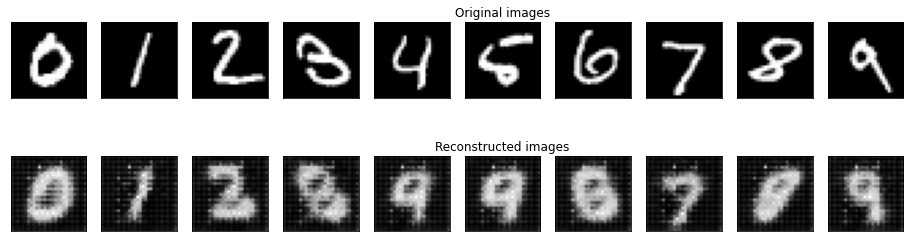

	 partial train loss (single batch): 50407.687500
	 partial train loss (single batch): 50102.707031
	 partial train loss (single batch): 51050.632812
	 partial train loss (single batch): 50575.398438
	 partial train loss (single batch): 49716.003906
	 partial train loss (single batch): 49896.753906
	 partial train loss (single batch): 49844.273438
	 partial train loss (single batch): 49791.691406
	 partial train loss (single batch): 49156.273438
	 partial train loss (single batch): 49139.734375
	 partial train loss (single batch): 49137.355469
	 partial train loss (single batch): 48198.937500
	 partial train loss (single batch): 49308.757812
	 partial train loss (single batch): 49141.726562
	 partial train loss (single batch): 49417.117188
	 partial train loss (single batch): 48478.687500
	 partial train loss (single batch): 50200.738281
	 partial train loss (single batch): 48357.207031
	 partial train loss (single batch): 48618.515625
	 partial train loss (single batch): 49422.117188


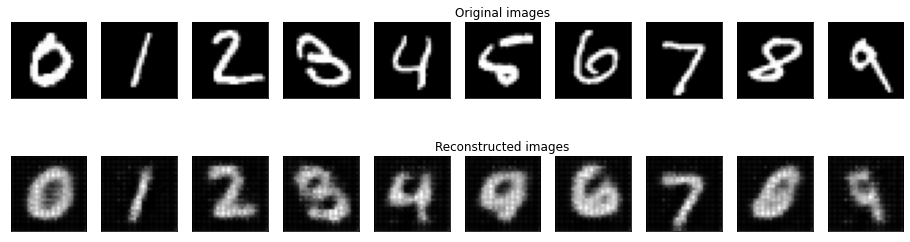

	 partial train loss (single batch): 41266.507812
	 partial train loss (single batch): 41456.210938
	 partial train loss (single batch): 41982.261719
	 partial train loss (single batch): 41542.042969
	 partial train loss (single batch): 40679.652344
	 partial train loss (single batch): 41243.156250
	 partial train loss (single batch): 41167.652344
	 partial train loss (single batch): 41102.281250
	 partial train loss (single batch): 40295.625000
	 partial train loss (single batch): 40191.667969
	 partial train loss (single batch): 40348.171875
	 partial train loss (single batch): 39543.144531
	 partial train loss (single batch): 40798.941406
	 partial train loss (single batch): 40641.320312
	 partial train loss (single batch): 41315.718750
	 partial train loss (single batch): 40019.867188
	 partial train loss (single batch): 42062.785156
	 partial train loss (single batch): 40121.933594
	 partial train loss (single batch): 40204.609375
	 partial train loss (single batch): 41137.242188


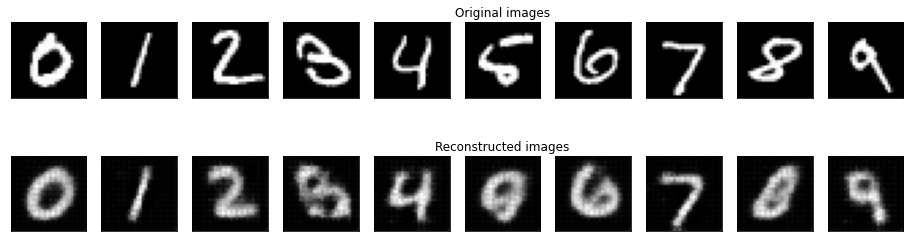

	 partial train loss (single batch): 37653.050781
	 partial train loss (single batch): 38199.554688
	 partial train loss (single batch): 38337.375000
	 partial train loss (single batch): 38123.937500
	 partial train loss (single batch): 37244.136719
	 partial train loss (single batch): 37971.781250
	 partial train loss (single batch): 37862.683594
	 partial train loss (single batch): 37611.171875
	 partial train loss (single batch): 36759.179688
	 partial train loss (single batch): 36843.453125
	 partial train loss (single batch): 37017.839844
	 partial train loss (single batch): 36225.886719
	 partial train loss (single batch): 37351.281250
	 partial train loss (single batch): 37422.726562
	 partial train loss (single batch): 37967.390625
	 partial train loss (single batch): 36718.152344
	 partial train loss (single batch): 38498.804688
	 partial train loss (single batch): 36756.988281
	 partial train loss (single batch): 36907.640625
	 partial train loss (single batch): 37955.171875


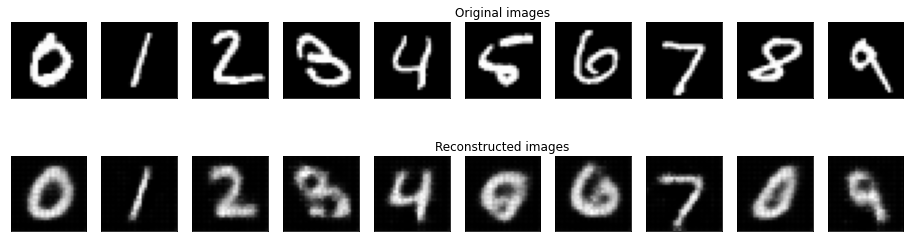

	 partial train loss (single batch): 36153.242188
	 partial train loss (single batch): 36833.394531
	 partial train loss (single batch): 36800.246094
	 partial train loss (single batch): 36564.250000
	 partial train loss (single batch): 35769.230469
	 partial train loss (single batch): 36394.359375
	 partial train loss (single batch): 36181.992188
	 partial train loss (single batch): 36133.269531
	 partial train loss (single batch): 35194.730469
	 partial train loss (single batch): 35169.500000
	 partial train loss (single batch): 35421.261719
	 partial train loss (single batch): 34884.554688
	 partial train loss (single batch): 35894.945312
	 partial train loss (single batch): 35931.203125
	 partial train loss (single batch): 36396.984375
	 partial train loss (single batch): 35429.121094
	 partial train loss (single batch): 37069.226562
	 partial train loss (single batch): 35281.937500
	 partial train loss (single batch): 35570.000000
	 partial train loss (single batch): 36601.292969


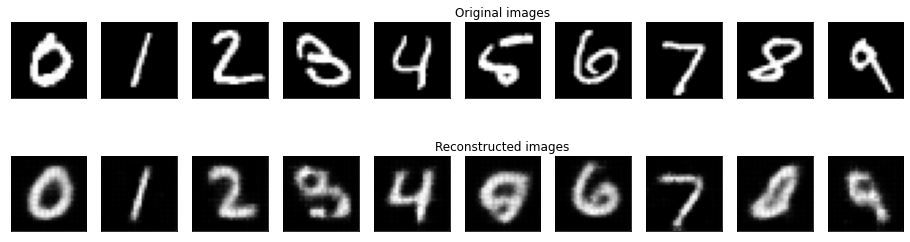

	 partial train loss (single batch): 35340.785156
	 partial train loss (single batch): 35800.367188
	 partial train loss (single batch): 35913.718750
	 partial train loss (single batch): 35612.289062
	 partial train loss (single batch): 34940.359375
	 partial train loss (single batch): 35693.941406
	 partial train loss (single batch): 35444.312500
	 partial train loss (single batch): 35487.312500
	 partial train loss (single batch): 34191.957031
	 partial train loss (single batch): 34210.136719
	 partial train loss (single batch): 34607.257812
	 partial train loss (single batch): 34026.222656
	 partial train loss (single batch): 35068.640625
	 partial train loss (single batch): 34993.640625
	 partial train loss (single batch): 35651.160156
	 partial train loss (single batch): 34773.687500
	 partial train loss (single batch): 36369.648438
	 partial train loss (single batch): 34481.679688
	 partial train loss (single batch): 34743.492188
	 partial train loss (single batch): 35760.246094


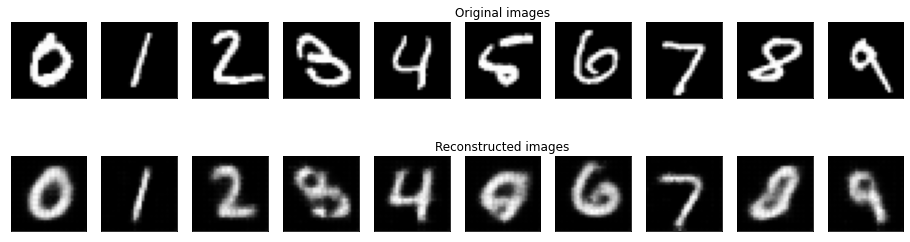

	 partial train loss (single batch): 34630.792969
	 partial train loss (single batch): 35228.066406
	 partial train loss (single batch): 35424.136719
	 partial train loss (single batch): 35132.488281
	 partial train loss (single batch): 34298.000000
	 partial train loss (single batch): 35020.324219
	 partial train loss (single batch): 34818.488281
	 partial train loss (single batch): 34987.332031
	 partial train loss (single batch): 33779.753906
	 partial train loss (single batch): 33793.617188
	 partial train loss (single batch): 34019.824219
	 partial train loss (single batch): 33605.511719
	 partial train loss (single batch): 34489.710938
	 partial train loss (single batch): 34468.785156
	 partial train loss (single batch): 35073.625000
	 partial train loss (single batch): 34221.820312
	 partial train loss (single batch): 35766.007812
	 partial train loss (single batch): 33909.421875
	 partial train loss (single batch): 34142.468750
	 partial train loss (single batch): 35149.421875


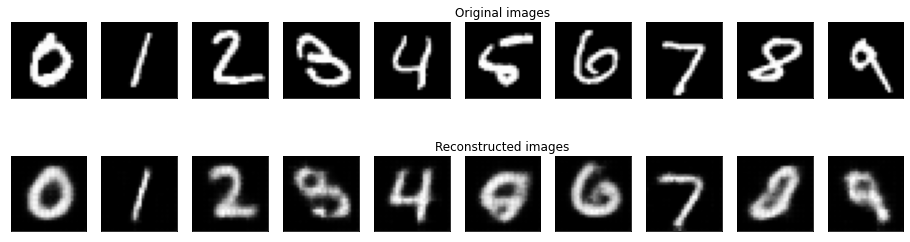

	 partial train loss (single batch): 34210.449219
	 partial train loss (single batch): 34836.261719
	 partial train loss (single batch): 35094.000000
	 partial train loss (single batch): 34792.304688
	 partial train loss (single batch): 33787.542969
	 partial train loss (single batch): 34665.214844
	 partial train loss (single batch): 34514.847656
	 partial train loss (single batch): 34424.312500
	 partial train loss (single batch): 33267.402344
	 partial train loss (single batch): 33199.234375
	 partial train loss (single batch): 33452.742188
	 partial train loss (single batch): 33145.574219
	 partial train loss (single batch): 34051.117188
	 partial train loss (single batch): 34005.179688
	 partial train loss (single batch): 34541.183594
	 partial train loss (single batch): 33794.101562
	 partial train loss (single batch): 35295.296875
	 partial train loss (single batch): 33537.238281
	 partial train loss (single batch): 33747.363281
	 partial train loss (single batch): 34817.867188


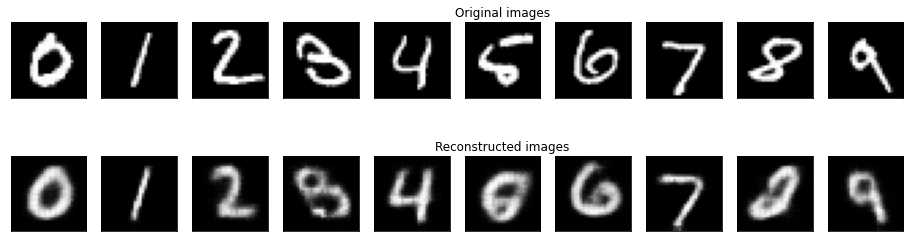

	 partial train loss (single batch): 34117.574219
	 partial train loss (single batch): 34559.746094
	 partial train loss (single batch): 34792.511719
	 partial train loss (single batch): 34448.445312
	 partial train loss (single batch): 33449.871094
	 partial train loss (single batch): 34332.328125
	 partial train loss (single batch): 34222.695312
	 partial train loss (single batch): 34116.984375
	 partial train loss (single batch): 33003.640625
	 partial train loss (single batch): 32801.921875
	 partial train loss (single batch): 33409.699219
	 partial train loss (single batch): 32834.019531
	 partial train loss (single batch): 33760.007812
	 partial train loss (single batch): 33680.824219
	 partial train loss (single batch): 34339.980469
	 partial train loss (single batch): 33501.722656
	 partial train loss (single batch): 35050.593750
	 partial train loss (single batch): 33103.910156
	 partial train loss (single batch): 33486.363281
	 partial train loss (single batch): 34459.730469


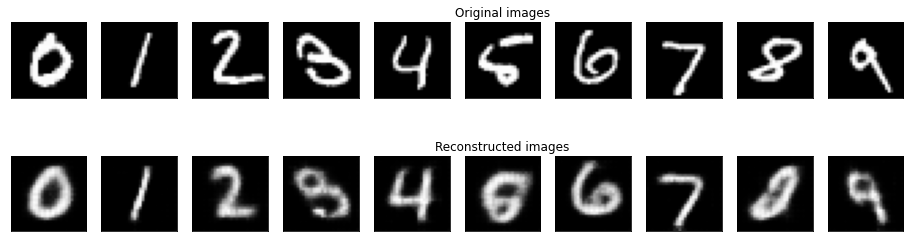

In [10]:
num_epochs = 10

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)

## generate new images by drawing latent vectors from the prior distribution

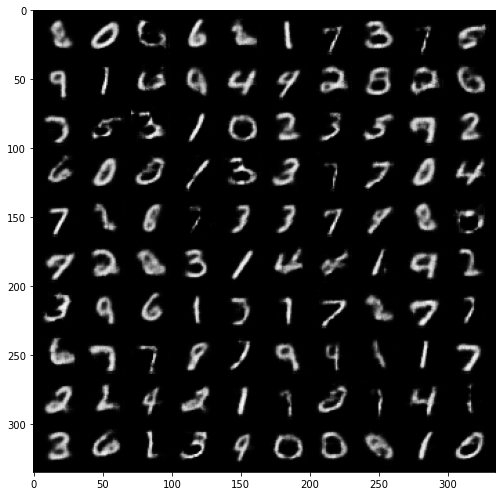

In [11]:
def show_image(img):

  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

  # sample latent vectors from the normal distribution
  latent = torch.randn(128, d, device=device)

  # reconstruct images from the latent vectors
  img_recon = vae.decoder(latent)
  img_recon = img_recon.cpu()

  fig, ax = plt.subplots(figsize=(20, 8.5))
  show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
  plt.show()

## Visualise the latent code

In [15]:
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

In [16]:
encoded_samples = []
for sample in tqdm(test_dataset):
  img = sample[0].unsqueeze(0).to(device)
  label = sample[1]
  # Encode image
  vae.eval()
  with torch.no_grad():
      encoded_img  = vae.encoder(img)
  # Append to list
  encoded_img = encoded_img.flatten().cpu().numpy()
  encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
  encoded_sample['label'] = label
  encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 10000/10000 [00:12<00:00, 789.71it/s]


The range of values of the latent space is smaller and more centralized. The overall distribution seems close to a Gaussian distribution.

A better visualization can be obtained applying the t-SNE, a reduction dimensionality method. With two components, I can visualize the latent code:

In [17]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

